# L2: Build Customized RAG

On this Notebook, we will create our customized RAG pipeline and to customize its behaviour. 
First, we will create a pipeline to retrieve and store the documents, which we will use later on in our RAG pipeline.

Our objective in our RAG pipeline is to work with retrieval augmented generation, where we fetch certain documents or information and we process it through an LLM, obtaining more concise answers related to our queries.

We start first importing the environment where we host some variables we need. We will also import already some modules from the Haystack library so we can see what elements we will use.

In [1]:
import sys

sys.path.append("..")

In [2]:
import os
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [3]:
from haystack import Pipeline
from haystack.utils.auth import Secret
from haystack.components.builders import PromptBuilder
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.embedders import  SentenceTransformersTextEmbedder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.preprocessors.document_splitter import DocumentSplitter


from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder, CohereTextEmbedder

2025-06-19 01:16:42.916981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-19 01:16:43.084679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-19 01:16:43.085173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-19 01:16:43.253262: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-19 01:16:45.550204: W tensorflow/compiler/tf

Note: For using cohere, you may need to install this additional library.

If you don't have cohere installed and doesn't appear here, install it by uncommenting the following line and restarting the kernel.

In [4]:
%pip list | grep cohere-haystack

cohere-haystack           4.2.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
#%pip install cohere-haystack

## Indexing Documents


For indexing the document in haystack, we are going to use the following elements:
1. Fetcher ([`LinkContentFetcher`](https://docs.haystack.deepset.ai/docs/linkcontentfetcher?utm_campaign=developer-relations&utm_source=dlai)): The fetcher will grab documents from a specific location or from a link and return the information streams.
2. Converter (e.g., [`HTMLToDocument`](https://docs.haystack.deepset.ai/docs/htmltodocument?utm_campaign=developer-relations&utm_source=dlai)):  The converter takes the raw information from the fetcher, opens them, reads the content, and packages it text into a standard Haystack Document object.
3. splitter (['DocumentSplitter'](https://docs.haystack.deepset.ai/docs/documentsplitter)): The splitter is optional. When used, it takes the Document objects (which might be very long) and chops them into the smaller, consistently-sized chunks you need for performance.

4. embedder (e.g., [Embedder](https://docs.haystack.deepset.ai/docs/embedders?utm_campaign=developer-relations&utm_source=dlai) or [Generator](https://docs.haystack.deepset.ai/docs/generators?utm_campaign=developer-relations&utm_source=dlai) options. For this lesson, we recomment Cohere embedders, or small [Sentence Transformers](https://docs.haystack.deepset.ai/docs/sentencetransformersdocumentembedder?utm_campaign=developer-relations&utm_source=dlai) embedders.): The embedder takes each document and uses a model to calculate its vector embedding, which captures its semantic meaning.
5. writer ([DocumentWriter](https://docs.haystack.deepset.ai/docs/documentwriter)): Once we have the embedding values, we can finally store these documents (along with these values) into a DocumentStore, from which we can call back later in other pipelines.

In the original reference from Haystack, the indexing pipeline doesn't use splitter. Then, why use it?

When working with less powerfull models as we run this ipynb in local, having a splitter will make the difference in speed and performance for using the current documents we have in store for future RAG pipelines.

We are going to see how the documents turn using two options:

*   Option A we will use a free model for embedding (All-MiniLM-L6).
*   Option B we will use a free trial model for embedding (Cohere)

For option A, lets try to run this with a complete free Document Embedder like all MiniLM L6

In [6]:
## Option A -- all-MiniLM-L6-v2 ##

# 1 Fetcher
fetcher = LinkContentFetcher()
# 2 Converter
converter = HTMLToDocument()
# 3 Splitter
document_splitter = DocumentSplitter(
    split_by="word",      # Split the text based on words.
    split_length=256,     # The target length of each chunk (in words).
    split_overlap=32      # Number of words to overlap between chunks to avoid losing context at the edges.
)

# 4 Embedder
embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
# 5 Writer
document_store = InMemoryDocumentStore() # ( We need a store object where we will write our documents)
writer = DocumentWriter(document_store=document_store)

# We add the components to the pipeline
indexing = Pipeline()
indexing.add_component("fetcher", fetcher)
indexing.add_component("converter", converter)
indexing.add_component("splitter", document_splitter)
indexing.add_component("embedder", embedder)
indexing.add_component("writer", writer)

# And we connect them
indexing.connect("fetcher.streams", "converter.sources")
indexing.connect("converter", "splitter")
indexing.connect("splitter", "embedder")
indexing.connect("embedder", "writer")



🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - splitter: DocumentSplitter
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

Let's see how the diagram look

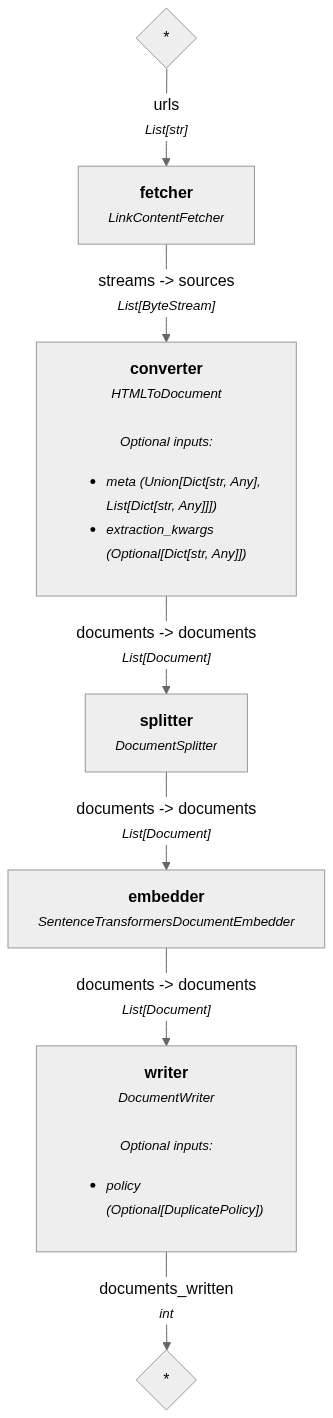

In [7]:
indexing.show()

Let's fetch some information about Cohere from haystack and store it into internal documents.

In [8]:
indexing.run(
    {
        "fetcher": {
            "urls": [
                "https://haystack.deepset.ai/integrations/cohere",
                "https://haystack.deepset.ai/integrations/anthropic",
                "https://haystack.deepset.ai/integrations/jina",
                "https://haystack.deepset.ai/integrations/nvidia",
            ]
        }
    }
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'writer': {'documents_written': 9}}

Let's take a look to the result :

In [9]:
document_store.filter_documents()[0]

Document(id=b990d5968a2b072be752748030b07c24f167a201d4e776588f38e972b3afdfc2, content: 'Integration: Cohere
Use Cohere models with Haystack
Table of Contents
Overview
You can use Cohere Mo...', meta: {'content_type': 'text/html', 'url': 'https://haystack.deepset.ai/integrations/cohere', 'source_id': '582fbd42fd8327c8d1e3c40c15ad161d874a1264401c3a74e85ffb4731c72b5a', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0, '_split_overlap': [{'doc_id': '38aed727b02d8ddb68d9733e20b2c5130517f5f3eb576c241e68731edfbc9e87', 'range': (0, 383)}]}, embedding: vector of size 384)

Let's try also to create another documment store and run it with option B, the cohere document embedder.

In [10]:
## Option B -- all-MiniLM-L6-v2 ##

# 1 Fetcher
fetcher = LinkContentFetcher()
# 2 Converter
converter = HTMLToDocument()
# 3 Splitter
document_splitter = DocumentSplitter(
    split_by="word",      # Split the text based on words.
    split_length=256,     # The target length of each chunk (in words).
    split_overlap=32      # Number of words to overlap between chunks to avoid losing context at the edges.
)

# 4 Embedder
# Note: os.getenv("CO_API_URL")
embedder = CohereDocumentEmbedder()
# 5 Writer
document_store_B = InMemoryDocumentStore() # ( We need a store object where we will write our documents)
writer = DocumentWriter(document_store=document_store_B)

# We add the components to the pipeline
indexing_B = Pipeline()
indexing_B.add_component("fetcher", fetcher)
indexing_B.add_component("converter", converter)
indexing_B.add_component("splitter", document_splitter)
indexing_B.add_component("embedder", embedder)
indexing_B.add_component("writer", writer)

# And we connect them
indexing_B.connect("fetcher.streams", "converter.sources")
indexing_B.connect("converter", "splitter")
indexing_B.connect("splitter", "embedder")
indexing_B.connect("embedder", "writer")


🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - splitter: DocumentSplitter
  - embedder: CohereDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

In [11]:
indexing_B.run(
    {
        "fetcher": {
            "urls": [
                "https://haystack.deepset.ai/integrations/cohere",
                "https://haystack.deepset.ai/integrations/anthropic",
                "https://haystack.deepset.ai/integrations/jina",
                "https://haystack.deepset.ai/integrations/nvidia",
            ]
        }
    }
)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


{'embedder': {'meta': ApiMeta(api_version=ApiMetaApiVersion(version='2', is_deprecated=None, is_experimental=None), billed_units=ApiMetaBilledUnits(images=None, input_tokens=4207.0, output_tokens=None, search_units=None, classifications=None), tokens=None, warnings=None)},
 'writer': {'documents_written': 9}}

Let's take a quick side by side comparison : The document content seems pretty similar. Taking a closer look, we can see there is some difference with the embedding: Option A shows embedding vectors of 384 size ( same as the range) while option B shows a larger range for the embeddings ( up to 4096 ).

In [12]:
document_store_B.filter_documents()[0]

Document(id=b990d5968a2b072be752748030b07c24f167a201d4e776588f38e972b3afdfc2, content: 'Integration: Cohere
Use Cohere models with Haystack
Table of Contents
Overview
You can use Cohere Mo...', meta: {'content_type': 'text/html', 'url': 'https://haystack.deepset.ai/integrations/cohere', 'source_id': '582fbd42fd8327c8d1e3c40c15ad161d874a1264401c3a74e85ffb4731c72b5a', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0, '_split_overlap': [{'doc_id': '38aed727b02d8ddb68d9733e20b2c5130517f5f3eb576c241e68731edfbc9e87', 'range': (0, 383)}]}, embedding: vector of size 4096)

In [13]:
document_store.filter_documents()[0]

Document(id=b990d5968a2b072be752748030b07c24f167a201d4e776588f38e972b3afdfc2, content: 'Integration: Cohere
Use Cohere models with Haystack
Table of Contents
Overview
You can use Cohere Mo...', meta: {'content_type': 'text/html', 'url': 'https://haystack.deepset.ai/integrations/cohere', 'source_id': '582fbd42fd8327c8d1e3c40c15ad161d874a1264401c3a74e85ffb4731c72b5a', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0, '_split_overlap': [{'doc_id': '38aed727b02d8ddb68d9733e20b2c5130517f5f3eb576c241e68731edfbc9e87', 'range': (0, 383)}]}, embedding: vector of size 384)

## Retrieval Augmented Generation

### 1. Creating a prompt

The first thing we need to do for creating our Retrieval Augmented Generation (RAG) pipeline is to decide what type of promt we will use to obtain the information. The prompt will shape the type of answer we will obtain from the query the user decides to send. We will create a promt with the component [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder?utm_campaign=developer-relations&utm_source=dlai), which uses  [Jinja templating](https://jinja.palletsprojects.com/en/3.1.x/)

These are two examples of prompt we can use. We can start with a simple prompt.

In [14]:
prompt = """
Answer the question based on the provided context.
Context:
{% for doc in documents %}
   {{ doc.content }} 
{% endfor %}
Question: {{ query }}
"""

We will realize we need to update our prompts as the augmented generation part might not always work as we expect. For example, here we will update the query if we don't find related information to our query.

In [15]:
promt = """

Based *only* on the following context, answer the user's query.
If the context doesn't contain the answer, say "Information not found".

Context:
{% for doc in documents %}
   {{ doc.content }} 
{% endfor %}

Query: {{ query }}
Answer:

"""

### 2. Initializing the LLM, our prompt processor :

When building our RAG pipeline, we are going to need an LLM, which will be the component that will shape the answer based on the query and the information it has at hand. This information will come in form of data and embeddings. The data will be the information to be used, and the embedding is what will make our LLM "understand" or relate the meaning of this information to the query.

We need to have our LLM running in a local server we can connect with. I am running my LLM from ['LMStudio'](https://lmstudio.ai/).
For this example, I am running phi-3-mini-4k-instruct, which I have defined in my environment variables, as well as the local address of my server.

In [16]:
from helper import get_env_var
API_BASE_URL = get_env_var("API_BASE_URL")

In [17]:
from haystack.utils import Secret

llm = OpenAIGenerator(
    api_base_url=API_BASE_URL,
    api_key=Secret.from_token("not-needed"),
    model="phi-3-mini-4k-instruct",
    timeout=360) 

### 3. Building a pipeline

Now that we have introduced the most important components for the pipeline, we can add the rest of the needed components to create our simple RAG pipeline.

We can decide again if we want to use a TextEmbedder using all-MiniLM or if we prefer other component, as for example Cohere offers.
I will leave commented out and you can try what option you like the most this time !

The only thing you need to have in mind is that depending the embedder you use now, you need to use a compatible embedder when writing the document stores: *The vector size has to match*.

In [18]:

# 1 Embedder
query_embedder = CohereTextEmbedder()
#query_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
# 2 Retriever
retriever = InMemoryEmbeddingRetriever(document_store=document_store_B)
# 3 Prompt Builder
prompt_builder = PromptBuilder(template=prompt)

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", llm)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


🚅 Components
  - query_embedder: CohereTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

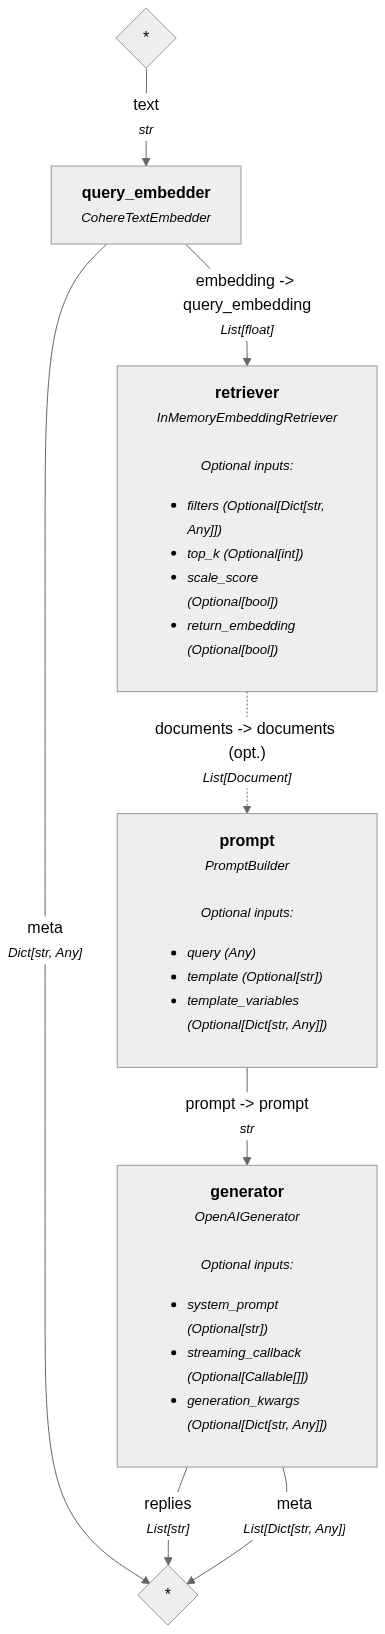

In [19]:
rag.show()

Note: Would you like to know what is going on while running this pipeline? you can import Haystack_Logs() from the file "haystack_lib.py" to have a look "under the hood".

In [20]:
question = "How can I use Cohere with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question},
    }
)

print(result["generator"]["replies"][0])

 To use Cohere with Haystack, follow these steps:

1. Installation:
First, install the required package by running the following command in your terminal or command prompt:
```
pip install cohere-haystack
```

2. Integrating Cohere Models into a Pipeline:
To integrate Cohere Models (Embedder and Generator) with Haystack, you need to add them as components in the pipeline:

a. Embedding Models:
For semantic document embeddings, use either `CohereTextEmbedder` or `CohereDocumentEmbedder`. To create an indexing pipeline using these models, follow the example provided below:

```python
from haystack import DocumentStore, Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder
from haystack_integrations.components.writers.document_writer import DocumentWriter

documents = [
    Document(content="My name is Wolfgang and I live in Berlin"),
    Document(content="I saw a black horse runni

For reference, this is is how this pipeline would look with a more powerful generator such a gpt.

But also, for reference I have also obtained this type of output from allMini :

If you don't get it right at the first try, there are things still to be done to improve!

### 3. Customize The Behaviour

Let's update the prompt to obtain some better results, maybe closer to what we obtained in the last message.

In [21]:
prompt = """
You will be provided some context, followed by the URL that this context comes from.
Answer the question based on the context, and reference the URL from which your answer is generated.
Your answer should be in {{ language }}.
Context:
{% for doc in documents %}
   {{ doc.content }} 
   URL: {{ doc.meta['url']}}
{% endfor %}
Question: {{ query }}
Answer:
"""

Let's try to keep the same components so we try to minimize the changes we are having and see the value of the prompt.

In [22]:
query_embedder = CohereTextEmbedder()
retriever = InMemoryEmbeddingRetriever(document_store=document_store_B)
prompt_builder = PromptBuilder(template=prompt)
generator = OpenAIGenerator(
                                api_base_url=API_BASE_URL,
                                api_key=Secret.from_token("not-needed"),
                                model="phi-3-mini-4k-instruct",
                                timeout=360) 

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

PromptBuilder has 3 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


🚅 Components
  - query_embedder: CohereTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

Running almost the same pipeline with the new prompt, we can see how we have obtained and excellent answer with a local model in a very short time !

In [24]:
question = "How can I use Cohere with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question, "language": "Spanish"},
    }
)

print(result["generator"]["replies"][0])

 Para usar Cohere con Haystack, puedes utilizar los modelos de Cohere en tus pipelines de Haystack mediante Generadores y Embedders (como CohereTextEmbedder y CohereDocumentEmbedder). Para instalarlo, debes ejecutar el comando `pip install cohere-haystack`. Puedes crear embeddings semánticos para documentos usando CohereDocumentEmbedder en tu pipeline de indexación y generar embeddings para consultas con CohereTextEmbedder. También puedes usar modelos generativos (LLMs) de Cohere como CohereGenerator en una pipeline de respuesta a preguntas utilizando PromptBuilder. El código ejemplo proporcionado puede ayudarte a entender cómo integrarlos en tu pipeline: https://haystack.deepset.ai/integrations/cohere
